In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import decomposition


import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML



from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mda

import string

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\oykuk\anaconda3\lib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Data Cleaning

In [2]:
# Reading the data
data = pd.read_csv('data/speed_dating.csv', encoding='ISO-8859-1')
data.shape

(8378, 195)

In [3]:
data.head()

iid   id  gender  idg  condtn  wave  round  position  positin1  order  ...  \
0    1  1.0       0    1       1     1     10         7       NaN      4  ...   
1    1  1.0       0    1       1     1     10         7       NaN      3  ...   
2    1  1.0       0    1       1     1     10         7       NaN     10  ...   
3    1  1.0       0    1       1     1     10         7       NaN      5  ...   
4    1  1.0       0    1       1     1     10         7       NaN      7  ...   

   attr3_3  sinc3_3  intel3_3  fun3_3  amb3_3  attr5_3  sinc5_3  intel5_3  \
0      5.0      7.0       7.0     7.0     7.0      NaN      NaN       NaN   
1      5.0      7.0       7.0     7.0     7.0      NaN      NaN       NaN   
2      5.0      7.0       7.0     7.0     7.0      NaN      NaN       NaN   
3      5.0      7.0       7.0     7.0     7.0      NaN      NaN       NaN   
4      5.0      7.0       7.0     7.0     7.0      NaN      NaN       NaN   

   fun5_3  amb5_3  
0     NaN     NaN  
1     NaN     NaN  
2     NaN     NaN  
3     NaN     NaN  
4     NaN     NaN  

[5 rows x 195 columns]

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
obj_cols = data.select_dtypes(include='object').columns
print(obj_cols)

Index(['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income',
       'career'],
      dtype='object')


In [6]:
#Filling field column, we have field_cd column that keeps numeric version of it.
#We will assign the empty ones 18 - Other and drop Field column

data['field_cd'].fillna(18, inplace=True)
data.drop('field', inplace=True, axis=1)
data['undergra'].fillna('other', inplace=True)

In [7]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatiser = WordNetLemmatizer()
    regex_rule = r'[^\w\s]'
    
    
    text = re.sub(regex_rule, " ", text)
    tokens = word_tokenize(text)

    filtered_sentence = []
    for w in tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    lemmas = [lemmatiser.lemmatize(token, pos='n').lower() for token in filtered_sentence]
    # Join lemmatized words with a space character
    return " ".join(lemmas)

In [8]:
preprocess_data = data['undergra'].apply(preprocess_text)

In [9]:
vectoriser = TfidfVectorizer(analyzer=word_tokenize)
data_tfidf = vectoriser.fit_transform(preprocess_data)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5,max_iter=50,doc_topic_prior=0.01,topic_word_prior=0.01)
lda = lda_model.fit(data_tfidf)
features_new = lda_model.transform(data_tfidf)

In [11]:
unique_values = np.unique(features_new)
num_unique_values = len(unique_values)
num_unique_values

413

In [12]:
features_new = pd.DataFrame(features_new)
data = pd.concat([data,features_new], axis=1)
data.drop('undergra',axis=1, inplace=True)

In [13]:
#Mnsat, tuition and income columns normally numeric values, we will change these columns

data['income'] = data['income'].str.replace(',', '')
data['income'] = pd.to_numeric(data['income'], errors='coerce')
data['mn_sat'] = pd.to_numeric(data['mn_sat'], errors='coerce')
data['tuition'] = pd.to_numeric(data['tuition'], errors='coerce')
data['zipcode'] = pd.to_numeric(data['zipcode'], errors='coerce')

In [14]:
all_na_rows = data[data.isna().all(axis=1)]
all_na_rows

Empty DataFrame
Columns: [iid, id, gender, idg, condtn, wave, round, position, positin1, order, partner, pid, match, int_corr, samerace, age_o, race_o, pf_o_att, pf_o_sin, pf_o_int, pf_o_fun, pf_o_amb, pf_o_sha, dec_o, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o, like_o, prob_o, met_o, age, field_cd, mn_sat, tuition, race, imprace, imprelig, from, zipcode, income, goal, date, go_out, career, career_c, sports, tvsports, exercise, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga, exphappy, expnum, attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1, attr4_1, sinc4_1, intel4_1, fun4_1, amb4_1, shar4_1, attr2_1, sinc2_1, intel2_1, fun2_1, amb2_1, shar2_1, attr3_1, sinc3_1, fun3_1, intel3_1, amb3_1, attr5_1, sinc5_1, intel5_1, fun5_1, amb5_1, dec, attr, sinc, intel, fun, ...]
Index: []

[0 rows x 198 columns]

In [15]:
drop_list = ['attr1_3','sinc1_3','intel1_3','fun1_3','amb1_3','shar1_3','attr7_3','sinc7_3','intel7_3','fun7_3','amb7_3','shar7_3','attr4_3','sinc4_3','intel4_3','fun4_3','amb4_3','shar4_3','attr2_3',
             'sinc2_3','intel2_3','fun2_3','amb2_3','shar2_3','attr3_3','sinc3_3','intel3_3','fun3_3','amb3_3','attr5_3','sinc5_3','intel5_3','fun5_3','amb5_3','attr7_2','sinc7_2','intel7_2','fun7_2',
             'amb7_2','shar7_2','attr1_2','sinc1_2','intel1_2','fun1_2','amb1_2','shar1_2','attr4_2','sinc4_2','intel4_2','fun4_2','amb4_2','shar4_2','attr2_2','sinc2_2','intel2_2','fun2_2','amb2_2',
             'shar2_2','attr3_2','sinc3_2','intel3_2','fun3_2','amb3_2','attr5_2','sinc5_2','intel5_2','fun5_2','amb5_2','attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s',
             'attr3_s','sinc3_s','intel3_s','fun3_s',
             'amb3_s','attr4_1','sinc4_1','intel4_1','fun4_1','amb4_1','shar4_1','order','iid','id','idg','round',
             'position','positin1','partner','pid','career','career_c','expnum',
             'you_call','them_cal','date_3','numdat_3','num_in_3','from','zipcode'
            ]

def dropping(df,lst):
    for e in lst:
        df.drop(e, axis=1,inplace=True)
        
    return df

dropping(data,drop_list)

gender  condtn  wave  match  int_corr  samerace  age_o  race_o  \
0          0       1     1      0      0.14         0   27.0     2.0   
1          0       1     1      0      0.54         0   22.0     2.0   
2          0       1     1      1      0.16         1   22.0     4.0   
3          0       1     1      1      0.61         0   23.0     2.0   
4          0       1     1      1      0.21         0   24.0     3.0   
5          0       1     1      0      0.25         0   25.0     2.0   
6          0       1     1      0      0.34         0   30.0     2.0   
7          0       1     1      0      0.50         0   27.0     2.0   
8          0       1     1      1      0.28         0   28.0     2.0   
9          0       1     1      0     -0.36         0   24.0     2.0   
10         0       1     1      0      0.29         1   27.0     2.0   
11         0       1     1      0      0.18         1   22.0     2.0   
12         0       1     1      0      0.10         0   22.0     4.0   
13         0       1     1      1     -0.21         1   23.0     2.0   
14         0       1     1      0      0.32         0   24.0     3.0   
15         0       1     1      0      0.73         1   25.0     2.0   
16         0       1     1      0      0.60         1   30.0     2.0   
17         0       1     1      0      0.07         1   27.0     2.0   
18         0       1     1      1      0.11         1   28.0     2.0   
19         0       1     1      0      0.39         1   24.0     2.0   
20         0       1     1      0     -0.24         1   27.0     2.0   
21         0       1     1      0     -0.14         1   22.0     2.0   
22         0       1     1      0      0.09         0   22.0     4.0   
23         0       1     1      0     -0.04         1   23.0     2.0   
24         0       1     1      0     -0.14         0   24.0     3.0   
25         0       1     1      0     -0.30         1   25.0     2.0   
26         0       1     1      0     -0.26         1   30.0     2.0   
27         0       1     1      0      0.29         1   27.0     2.0   
28         0       1     1      0     -0.15         1   28.0     2.0   
29         0       1     1      0     -0.47         1   24.0     2.0   
30         0       1     1      0     -0.18         1   27.0     2.0   
31         0       1     1      0     -0.18         1   22.0     2.0   
32         0       1     1      0      0.05         0   22.0     4.0   
33         0       1     1      1     -0.18         1   23.0     2.0   
34         0       1     1      0      0.21         0   24.0     3.0   
35         0       1     1      0      0.37         1   25.0     2.0   
36         0       1     1      0      0.35         1   30.0     2.0   
37         0       1     1      0      0.15         1   27.0     2.0   
38         0       1     1      1     -0.47         1   28.0     2.0   
39         0       1     1      0     -0.19         1   24.0     2.0   
40         0       1     1      0     -0.43         1   27.0     2.0   
41         0       1     1      0      0.00         1   22.0     2.0   
42         0       1     1      0     -0.17         0   22.0     4.0   
43         0       1     1      1      0.08         1   23.0     2.0   
44         0       1     1      0     -0.16         0   24.0     3.0   
45         0       1     1      0      0.06         1   25.0     2.0   
46         0       1     1      0     -0.05         1   30.0     2.0   
47         0       1     1      0      0.07         1   27.0     2.0   
48         0       1     1      1     -0.13         1   28.0     2.0   
49         0       1     1      0     -0.06         1   24.0     2.0   
50         0       1     1      0      0.33         0   27.0     2.0   
51         0       1     1      0      0.37         0   22.0     2.0   
52         0       1     1      0     -0.51         1   22.0     4.0   
53         0       1     1      1      0.12         0   23.0     2.0   
54         0       1     1      0      0.35   

In [16]:
scaler = MinMaxScaler()

scaler_list = ['attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','attr2_1','sinc2_1','intel2_1','fun2_1','amb2_1','shar2_1',
              'attr3_1','sinc3_1','intel3_1','fun3_1','amb3_1','attr5_1','sinc5_1','intel5_1','fun5_1','amb5_1']

def scalling(lst,df):
    for e in lst:
        e_standardized = scaler.fit_transform(df[e].values.reshape(-1, 1))
        df[e] = e_standardized
        
scalling(lst=scaler_list, df=data)     

In [17]:
# continuous values

continuous_df =data [['mn_sat','tuition','age','age_o','int_corr','income']]
continuous_df.head()
continuous_df.head()
(continuous_df.isnull().mean()*100).sort_values(ascending=False)

tuition     100.000000
mn_sat       99.665791
income       48.925758
int_corr      1.885892
age_o         1.241346
age           1.133922
dtype: float64

Since tuition and mn_sat columns have lots of missing data, we will drop them to not miss lead the model.

In [18]:
missing_values = ['tuition','mn_sat',]
continuous_df = dropping(continuous_df,missing_values)

In [19]:
# Explanation  isaida

In [20]:
#n_neighbors=2

data_imputer=KNNImputer(missing_values=np.nan, n_neighbors=2, weights='uniform', metric='nan_euclidean')
data_clean_imputed2 = pd.DataFrame(data_imputer.fit_transform(continuous_df), columns=continuous_df.columns)

In [21]:
# n_neighbors=5

data_imputer=KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')

data_clean_imputed5 = pd.DataFrame(data_imputer.fit_transform(continuous_df), columns=continuous_df.columns)

In [22]:
# n_neighbors=10

data_imputer=KNNImputer(missing_values=np.nan, n_neighbors=10, weights='uniform', metric='nan_euclidean')

data_clean_imputed10 = pd.DataFrame(data_imputer.fit_transform(continuous_df), columns=continuous_df.columns)

In [23]:
# 2 Vs 5

df1 = data_clean_imputed2
df2 = data_clean_imputed5

results = []

for col in df1.columns:
    valor1 = df1[col]
    valor2 = df2[col]
    
    t_stat, p_valor = ttest_ind(valor1, valor2)
    
    results.append({"column": col, "t_stat": t_stat, "p_valor": p_valor})
    
    for res in results:

        print("Column {}: t_stat = {:.2f}, p_valor = {:.3f}".format(res["column"], res["t_stat"], res["p_valor"]))

Column age: t_stat = -0.71, p_valor = 0.479
Column age: t_stat = -0.71, p_valor = 0.479
Column age_o: t_stat = -0.37, p_valor = 0.709
Column age: t_stat = -0.71, p_valor = 0.479
Column age_o: t_stat = -0.37, p_valor = 0.709
Column int_corr: t_stat = -0.04, p_valor = 0.965
Column age: t_stat = -0.71, p_valor = 0.479
Column age_o: t_stat = -0.37, p_valor = 0.709
Column int_corr: t_stat = -0.04, p_valor = 0.965
Column income: t_stat = -4.14, p_valor = 0.000


In [24]:
#5 Vs 10

df1 = data_clean_imputed5
df2 = data_clean_imputed10

results = []

for col in df1.columns:
    valor1 = df1[col]
    valor2 = df2[col]
    
    t_stat, p_valor = ttest_ind(valor1, valor2)
    
    results.append({"column": col, "t_stat": t_stat, "p_valor": p_valor})
    
for res in results:
     print("Column {}: t_stat = {:.2f}, p_valor = {:.3f}".format(res["column"], res["t_stat"], res["p_valor"]))

Column age: t_stat = 0.11, p_valor = 0.912
Column age_o: t_stat = 0.01, p_valor = 0.995
Column int_corr: t_stat = 0.02, p_valor = 0.981
Column income: t_stat = 0.66, p_valor = 0.509


An improvement of the t_stat and p_value values is noted as K increases. Therefore, I will select the final dataframe between k=5 and k=10. Initially, I could choose any of them because t_stat is low and p_value is larger than 0.05 when comparing them. But since the column that had the most imputations was income and in all cases it is the one with the highest t_stat value and lowest p_valor value, I am going to see the error of each column in detail.

In [25]:
mae_age = mean_absolute_error(data_clean_imputed5['age'], data_clean_imputed10['age'])
r2_age = r2_score(data_clean_imputed5['age'], data_clean_imputed10['age'])
print(f" MAE of age is: {mae_age:.5f}")
print(f" R2 of age is: {r2_age:.5f}")

 MAE of age is: 0.01102
 R2 of age is: 0.99875


In [26]:
mae_age_o = mean_absolute_error(data_clean_imputed5['age_o'], data_clean_imputed10['age_o'])
r2_age_o = r2_score(data_clean_imputed5['age_o'], data_clean_imputed10['age_o'])
print(f" MAE of age_o is: {mae_age:.5f}")
print(f" R2 of age_o is: {r2_age:.5f}")

 MAE of age_o is: 0.01102
 R2 of age_o is: 0.99875


In [27]:
mae_int = mean_absolute_error(data_clean_imputed5['int_corr'], data_clean_imputed10['int_corr'])
r2_int = r2_score(data_clean_imputed5['int_corr'], data_clean_imputed10['int_corr'])
print(f" MAE of int_corr is: {mae_int:.5f}")
print(f" R2 of int_corr is: {r2_int:.5f}")

 MAE of int_corr is: 0.00148
 R2 of int_corr is: 0.99810


In [28]:
mae_inc = mean_absolute_error(data_clean_imputed5['income'], data_clean_imputed10['income'])
r2_inc = r2_score(data_clean_imputed5['income'], data_clean_imputed10['income'])
print(f" MAE of income is: {mae_int:.5f}")
print(f" R2 of income is: {r2_int:.5f}")

 MAE of income is: 0.00148
 R2 of income is: 0.99810


As the r2 is very close in all cases and the mae of income is much lower than the average or standard deviation of any of the df. I am going to choose the dataframe with k=5 simply because it is faster to calculate. - isaida will check

In [29]:
cont_data_cleaned = data_clean_imputed5

In [30]:
#Categorical values
cont = ['age','age_o','int_corr']
categorical = dropping(data,cont)

In [31]:
null_counts = categorical.isnull().sum()
null_columns = null_counts[null_counts == 0]
null_columns

gender      0
condtn      0
wave        0
match       0
samerace    0
dec_o       0
field_cd    0
dec         0
0           0
1           0
2           0
3           0
4           0
dtype: int64

In [32]:
nominal = ['race_o','race','goal','date','go_out','exphappy','met','match_es','satis_2','length','numdat_2']
ordinal = ['pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o',
       'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o',
       'met_o', 'field_cd', 'imprace', 'imprelig', 'sports', 'tvsports',
       'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
       'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping',
       'yoga', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
       'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1',
       'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1',
       'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'like', 'prob']

In [33]:
categorical.columns

Index([  'gender',   'condtn',     'wave',    'match', 'samerace',   'race_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
          'dec_o',   'attr_o',   'sinc_o',  'intel_o',    'fun_o',    'amb_o',
         'shar_o',   'like_o',   'prob_o',    'met_o', 'field_cd',   'mn_sat',
        'tuition',     'race',  'imprace', 'imprelig',   'income',     'goal',
           'date',   'go_out',   'sports', 'tvsports', 'exercise',   'dining',
        'museums',      'art',   'hiking',   'gaming', 'clubbing',  'reading',
             'tv',  'theater',   'movies', 'concerts',    'music', 'shopping',
           'yoga', 'exphappy',  'attr1_1',  'sinc1_1', 'intel1_1',   'fun1_1',
         'amb1_1',  'shar1_1',  'attr2_1',  'sinc2_1', 'intel2_1',   'fun2_1',
         'amb2_1',  'shar2_1',  'attr3_1',  'sinc3_1',   'fun3_1', 'intel3_1',
         'amb3_1',  'attr5_1',  'sinc5_1', 'intel5_1',   'fun5_1',   'amb5_1',
            'dec',     'attr',     'sinc',    'intel

In [34]:
nominal_columns = ['race_o','race','goal','date','go_out','exphappy','met','match_es','satis_2','length','numdat_2']
nominal_df = categorical[nominal_columns]

imputer = SimpleImputer(strategy='most_frequent')
imputed_nominal_df = pd.DataFrame(imputer.fit_transform(nominal_df), columns=nominal_columns)

In [35]:
imputed_nominal_df.head()

race_o  race  goal  date  go_out  exphappy  met  match_es  satis_2  length  \
0     2.0   4.0   2.0   7.0     1.0       3.0  2.0       4.0      6.0     2.0   
1     2.0   4.0   2.0   7.0     1.0       3.0  1.0       4.0      6.0     2.0   
2     4.0   4.0   2.0   7.0     1.0       3.0  1.0       4.0      6.0     2.0   
3     2.0   4.0   2.0   7.0     1.0       3.0  2.0       4.0      6.0     2.0   
4     3.0   4.0   2.0   7.0     1.0       3.0  2.0       4.0      6.0     2.0   

   numdat_2  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0

In [36]:
nominal_df.describe()

race_o         race         goal         date       go_out  \
count  8305.000000  8315.000000  8299.000000  8281.000000  8299.000000   
mean      2.756653     2.757186     2.122063     5.006762     2.158091   
std       1.230689     1.230905     1.407181     1.444531     1.105246   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.000000     2.000000     1.000000     4.000000     1.000000   
50%       2.000000     2.000000     2.000000     5.000000     2.000000   
75%       4.000000     4.000000     2.000000     6.000000     3.000000   
max       6.000000     6.000000     6.000000     7.000000     7.000000   

          exphappy          met     match_es      satis_2       length  \
count  8277.000000  8003.000000  7205.000000  7463.000000  7463.000000   
mean      5.534131     0.948769     3.207814     5.711510     1.843495   
std       1.734059     0.989889     2.444813     1.820764     0.975662   
min       1.000000     0.000000     0.000000     1.000000     1.000000   
25%       5.000000     0.000000     2.000000     5.000000     1.000000   
50%       6.000000     0.000000     3.000000     6.000000     1.000000   
75%       7.000000     2.000000     4.000000     7.000000     3.000000   
max      10.000000     8.000000    18.000000    10.000000     3.000000   

          numdat_2  
count  7433.000000  
mean      2.338087  
std       0.631240  
min       1.000000  
25%       2.000000  
50%       2.000000  
75%       3.000000  
max       3.000000

In [37]:
imputed_nominal_df.describe()

race_o         race         goal         date       go_out  \
count  8378.000000  8378.000000  8378.000000  8378.000000  8378.000000   
mean      2.750060     2.751492     2.111482     5.018262     2.156601   
std       1.227331     1.228011     1.404722     1.440069     1.100129   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.000000     2.000000     1.000000     4.000000     1.000000   
50%       2.000000     2.000000     2.000000     5.000000     2.000000   
75%       4.000000     4.000000     2.000000     6.000000     3.000000   
max       6.000000     6.000000     6.000000     7.000000     7.000000   

          exphappy          met     match_es      satis_2       length  \
count  8378.000000  8378.000000  8378.000000  8378.000000  8378.000000   
mean      5.527692     0.906302     3.038709     5.743017     1.751373   
std       1.724559     0.987171     2.305609     1.720805     0.957688   
min       1.000000     0.000000     0.000000     1.000000     1.000000   
25%       5.000000     0.000000     2.000000     5.000000     1.000000   
50%       6.000000     0.000000     2.000000     6.000000     1.000000   
75%       7.000000     2.000000     4.000000     7.000000     3.000000   
max      10.000000     8.000000    18.000000    10.000000     3.000000   

          numdat_2  
count  8378.000000  
mean      2.299952  
std       0.604114  
min       1.000000  
25%       2.000000  
50%       2.000000  
75%       3.000000  
max       3.000000

The SimpleImputer with "most_frequent" strategy replaces missing values with the most frequent value in the column. When dealing with nominal categorical data, this can be a reasonable approach since the mode (most frequent value) is well-defined and provides a meaningful way to fill in the missing values.

Since the before and after dataframes are not statistically different, this suggests that the imputed values did not significantly change the distribution or summary statistics of the data.

In [38]:
ordinal_columns = ['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o', 'intel_o', 
                   'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'field_cd', 'imprace', 'imprelig', 'sports', 
                   'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
                   'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                   'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 
                   'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'attr', 'sinc', 
                   'intel', 'fun', 'amb', 'shar', 'like', 'prob']

ordinal_df = categorical[ordinal_columns]


In [39]:
imputer = SimpleImputer(strategy='most_frequent')
imputed_ordinal_df = pd.DataFrame(imputer.fit_transform(ordinal_df), columns=ordinal_columns)

In [40]:
@widgets.interact(column=imputed_ordinal_df.columns)
def categorical_graphs(column):
    display(HTML(f'<h2>Distribution for {column}<h2>'))
    sns.histplot(data=imputed_ordinal_df, x=column)
    plt.show()

interactive(children=(Dropdown(description='column', options=('pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', …

Our ordinal data displays a variety of distributions, including those that are normal or close to normal, skewed, and displaying regularly increasing values. 

To handle these different distributions, imputing with the most frequent value is a logical choice. 

This approach can help avoid changing the distribution for normal and skewed data. However, when dealing with data that exhibits regular increase points, it can be challenging to decide on a constant value to impute the missing values, as the increase points can vary over time. That is we will also use most frequent approach for them.

In [41]:
not_null_values = ['gender','condtn','wave','match','samerace','dec_o','dec']

In [42]:
# Final dataframe
imputed_cat_df = pd.concat([imputed_ordinal_df, imputed_nominal_df], axis=1)
imputed_cat_df = pd.concat([imputed_cat_df, categorical[not_null_values]], axis=1)
imputed_df = pd.concat([imputed_cat_df,cont_data_cleaned], axis=1)
final_data = pd.concat([imputed_df,features_new], axis=1)


In [43]:
final_data = final_data.rename(columns={0: 'col0', 1: 'col1', 2: 'col2', 3: 'col3', 4: 'col4'})

In [44]:
final_data.columns

Index(['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o',
       'prob_o', 'met_o', 'field_cd', 'imprace', 'imprelig', 'sports',
       'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
       'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music',
       'shopping', 'yoga', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
       'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
       'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1',
       'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'attr',
       'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'race_o', 'race',
       'goal', 'date', 'go_out', 'exphappy', 'met', 'match_es', 'satis_2',
       'length', 'numdat_2', 'gender', 'condtn', 'wave', 'match', 'samerace',
       'dec_o', 'dec', 'age', 'age_o', 'int_corr', 'income', 'col0', 'col1',
       'col2'

# 2. EDA

0    6998
1    1380
Name: match, dtype: int64

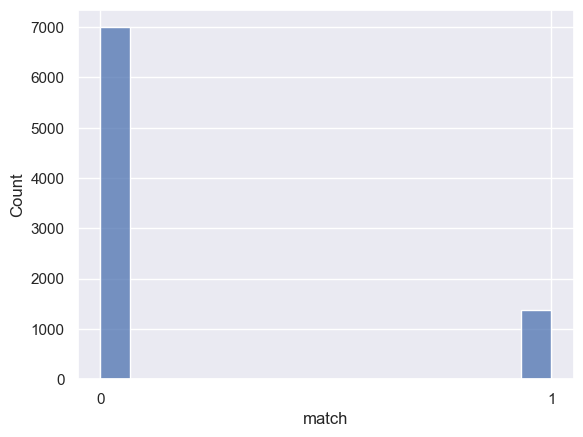

In [346]:
sns.histplot(data=final_data, x='match')
plt.xticks([0, 1], ['0', '1'])
final_data['match'].value_counts()

# check the graph

In our experiance there are total 8.378 speed date happend. Unfortunatly only %16 has a positive match.

In [347]:
correlation_matrix = final_data.corr()
match_correlations = correlation_matrix['match']
most_positively_correlated = round(match_correlations.sort_values(ascending=False), 2).head(11)[1:10]
most_negatively_correlated = round(match_correlations.sort_values(ascending=True),2).head(11)[1:11]

fig = go.Figure(data=[go.Table(
    header=dict(values=['Feature','Correlation'],
                line_color='coral',
                fill_color='coral',
                align='left'),
    cells=dict(values=[most_positively_correlated.keys().tolist(), most_positively_correlated.values,
                       ],
               line_color='coral',
               fill_color='cornsilk',
               align='left'
               ))])

fig = fig.update_layout(
        title= 'Top 10 Positive Correlated Features with Match Decision')

fig.show()

fig = go.Figure(data=[go.Table(
    header=dict(values=['Feature','Correlation'],
                line_color='darkturquoise',
                fill_color='darkturquoise',
                align='left'),
    cells=dict(values=[most_negatively_correlated.keys().tolist(), most_negatively_correlated.values,
                       ],
               line_color='darkturquoise',
               fill_color='aliceblue',
               align='left'
               ))])

fig = fig.update_layout(
        title= 'Top 10 Negative Correlated Features with Match Decision')

fig.show()

We can observe the most correlated features with the match decision is the each individual decision but this is not surprising. Among the features that we can interpret, having fun that night and sharing interests are the most significant ones. Additionally, liking each other is one of the main reasons for a match decision.

In terms of negative correlations with the match decision, we don't see any highly negative correlated features. However, age differences are the most important factor to consider.

Since the dataframe contains lots of different columns that contain different information for EDA, we will group the similar ones together and check them one by one.

In [348]:
hobies = final_data[['go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga','gender','match']]
final_data['age_dff'] = final_data['age'] - final_data['age_o']
race_rel = final_data[['samerace','race_o','race','imprace', 'imprelig','match','gender']]
partner_rate = final_data[['dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o','match','gender']]
partner_preferences = final_data[['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha','match','gender']]
edu_car = final_data[['field_cd','gender','match']]
history = final_data[['goal','date','go_out','exphappy','match','gender']]
preferences = final_data[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1','match','gender']]
opposite_preferences = final_data[['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1','match','gender']]
your_rate_general = final_data[['attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1','match','gender']]
other_rate_your_idea = final_data[['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1','match','gender']]
your_rate_partner = final_data[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar','like', 'prob', 'met','match','gender']]

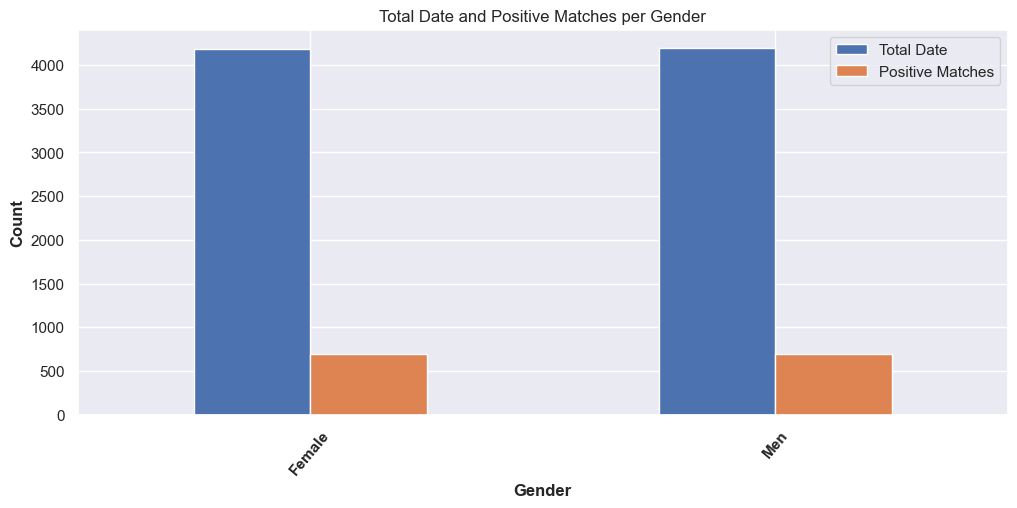

In [349]:
gender_df = final_data.groupby('gender').agg({'match': ['count', 'sum']})
gender_df.columns = ['total_date','positive_match']
gender_df = gender_df.reset_index()

figsize=(10,6)
fig, ax = plt.subplots()
gender_df.plot.bar(y=['total_date', 'positive_match'], rot=50, ax=ax)
ax.set_xlabel('Gender',fontweight='bold')
ax.set_ylabel('Count',fontweight='bold')
ax.legend(['Total Date', 'Positive Matches'])
ax.set_xticklabels(['Female', 'Men'], fontweight='bold')
sns.set(font_scale=1)
fig.set_size_inches(12, 5)
plt.title('Total Date and Positive Matches per Gender')
plt.show();



# Just show the match without gender

In [350]:
gender_df['gender'] = gender_df['gender'].replace({0: 'female', 1: 'male'})
gender_df['%'] = round((gender_df['positive_match'] / gender_df['total_date']) * 100,2)
gender_df.sort_values(by='total_date',ascending=False)

gender  total_date  positive_match      %
1    male        4194             690  16.45
0  female        4184             690  16.49

The gender distribution in the dataset is fairly balanced. However, it is worth noting that there are slightly more male participants, with only a difference of 100 participants.

In [351]:
race_rel['race_explanation'] = race_rel['race'].map({1:'Black/African American',2:'European/Caucasian-American',3:'Latino/Hispanic American',4:'Asian/Pacific Islander/Asian-American',5:'Native American',6:'Other'})
race_rel['race_o_explanation'] = race_rel['race_o'].map({1:'Black/African American',2:'European/Caucasian-American',3:'Latino/Hispanic American',4:'Asian/Pacific Islander/Asian-American',5:'Native American',6:'Other'})
race_exp_match = race_rel.groupby('race_explanation').agg({'match':['count','sum']})
race_exp_match.columns = ['total_date','positive_match']
race_exp_match = race_exp_match.reset_index()
race_exp_match['%'] = round((race_exp_match['positive_match'] / race_exp_match['total_date']) * 100,2)
race_exp_match.sort_values(by='total_date', ascending=False)
race_exp_match = race_exp_match.sort_values(by='total_date', ascending=False)
race_exp_match

race_explanation  total_date  positive_match      %
2            European/Caucasian-American        4790             802  16.74
0  Asian/Pacific Islander/Asian-American        1982             267  13.47
3               Latino/Hispanic American         664             123  18.52
4                                  Other         522             103  19.73
1                 Black/African American         420              85  20.24

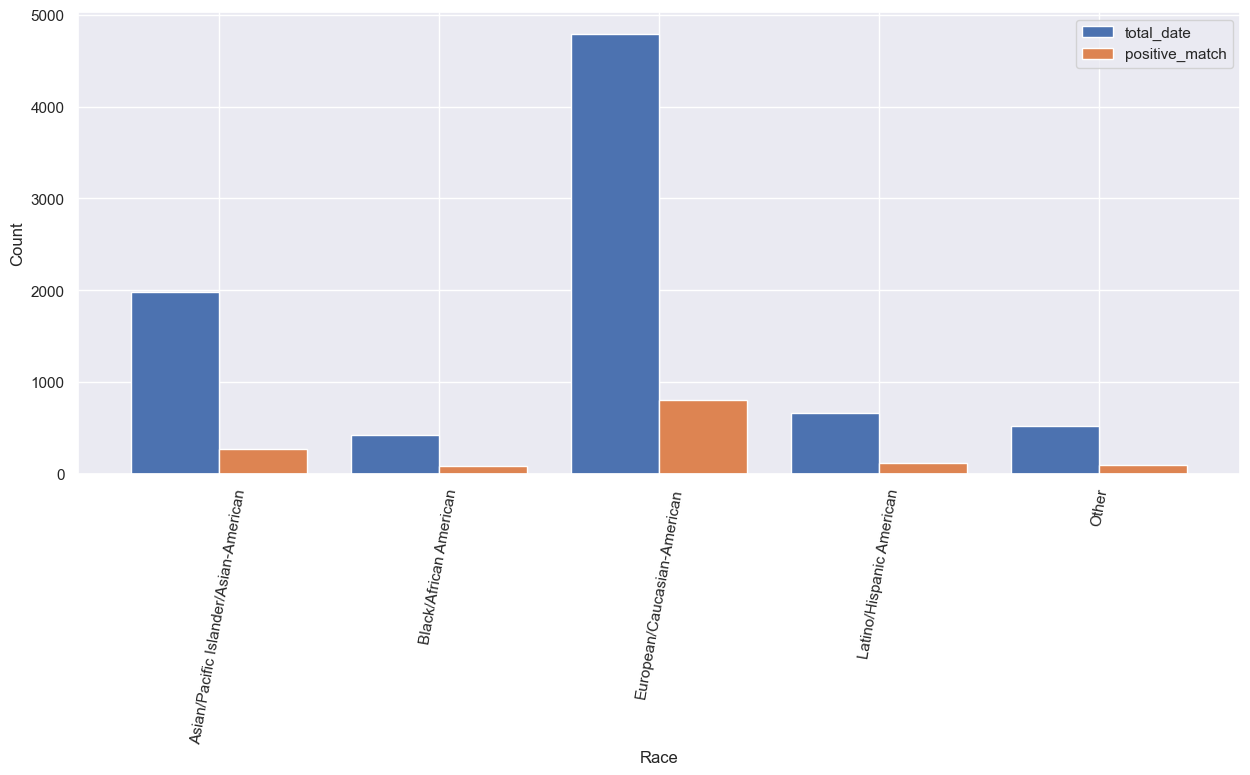

In [352]:
plt.figure(figsize=(15,6))

race_exp_match['race_explanation'] = pd.Categorical(race_exp_match['race_explanation'])

x_total = race_exp_match['race_explanation'].cat.codes - 0.2
x_positive = race_exp_match['race_explanation'].cat.codes + 0.2

plt.bar(x_total, race_exp_match['total_date'], width=0.4, label='total_date')
plt.bar(x_positive, race_exp_match['positive_match'], width=0.4, label='positive_match')

plt.xticks(ticks=race_exp_match['race_explanation'].cat.codes, labels=race_exp_match['race_explanation'], rotation=80)
plt.xlabel('Race')
plt.ylabel('Count')

plt.legend()
plt.show()

- Most of the participants in this experiment are European. 
- The group with the highest positive match percentage is Black/African American at 20%, but the total number of participants in this group is too low to generate a reliable statistic. 
- For Asian/Pacific Islander/Asian-American participants, even though they are the second biggest group, their positive match percentage is lower than other groups.

In [353]:
for race in race_rel['race'].unique():
    race_df = final_data[final_data['race'] == race]
    race_corr = round(race_df.corr()['match'].sort_values(ascending=False)[1:6],2)
    race_explanation = race_rel.loc[race_rel['race'] == race, 'race_explanation'].iloc[0]
    print(f"Top 5 Correlations for {race_explanation}:")
    print(race_corr)
    print()

Top 5 Correlations for Asian/Pacific Islander/Asian-American:
dec_o     0.55
dec       0.43
like_o    0.27
prob_o    0.25
shar_o    0.25
Name: match, dtype: float64

Top 5 Correlations for European/Caucasian-American:
dec       0.56
dec_o     0.49
like      0.32
like_o    0.29
fun       0.28
Name: match, dtype: float64

Top 5 Correlations for Other:
dec_o     0.62
dec       0.50
like_o    0.37
attr_o    0.34
shar_o    0.32
Name: match, dtype: float64

Top 5 Correlations for Latino/Hispanic American:
dec      0.58
dec_o    0.52
fun      0.32
like     0.32
attr     0.30
Name: match, dtype: float64

Top 5 Correlations for Black/African American:
dec_o     0.60
dec       0.50
like_o    0.36
shar_o    0.34
fun_o     0.34
Name: match, dtype: float64



1. Among Asian/Pacific Islander/Asian-American and Black/African American individuals, the ratings provided by other people appear to be the most correlated features.

2. It appears that among European/Caucasian-American individuals, liking each other is the most correlated feature.

3. It seems that among Latino/Hispanic American individuals, the ratings they provide for other people are the most correlated features.

<Figure size 2000x600 with 0 Axes>

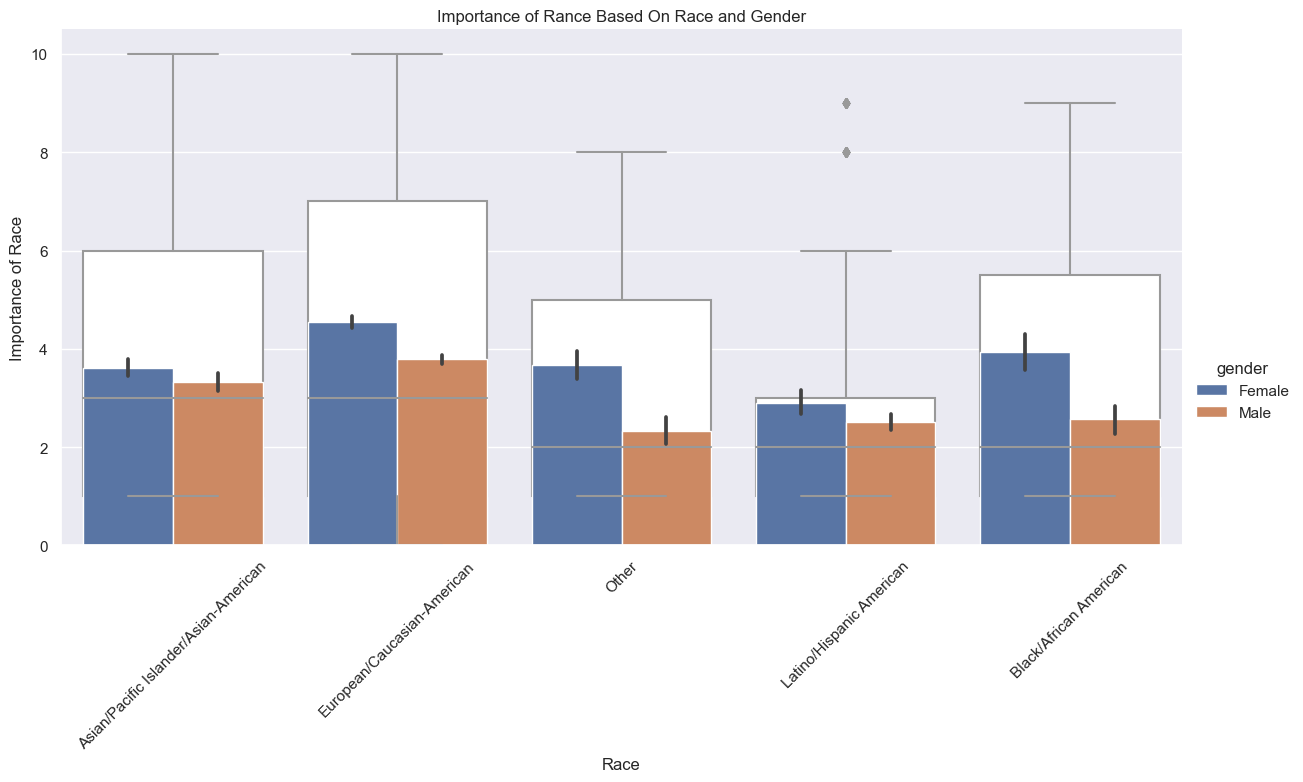

In [354]:
race_rel['gender'] = race_rel['gender'].replace({0: 'Female', 1: 'Male'})
plt.figure(figsize=(20,6))

# Create a bar plot with mean values
g = sns.catplot(x="race_explanation", y="imprace", hue="gender", kind="bar", data=race_rel, height=6, aspect=2)

# Create a box plot with outliers
sns.boxplot(x="race_explanation", y="imprace", data=race_rel, dodge=False, color="white", showfliers=True, ax=g.ax)

g.set_xticklabels(rotation=45)
plt.xlabel('Race')
plt.ylabel('Importance of Race')
plt.title('Importance of Rance Based On Race and Gender')

plt.show()

# Check match perception and behavior

1. On average, the highest importance to the race coming from European - American people.

2. Race is more important for Female

<Figure size 2000x600 with 0 Axes>

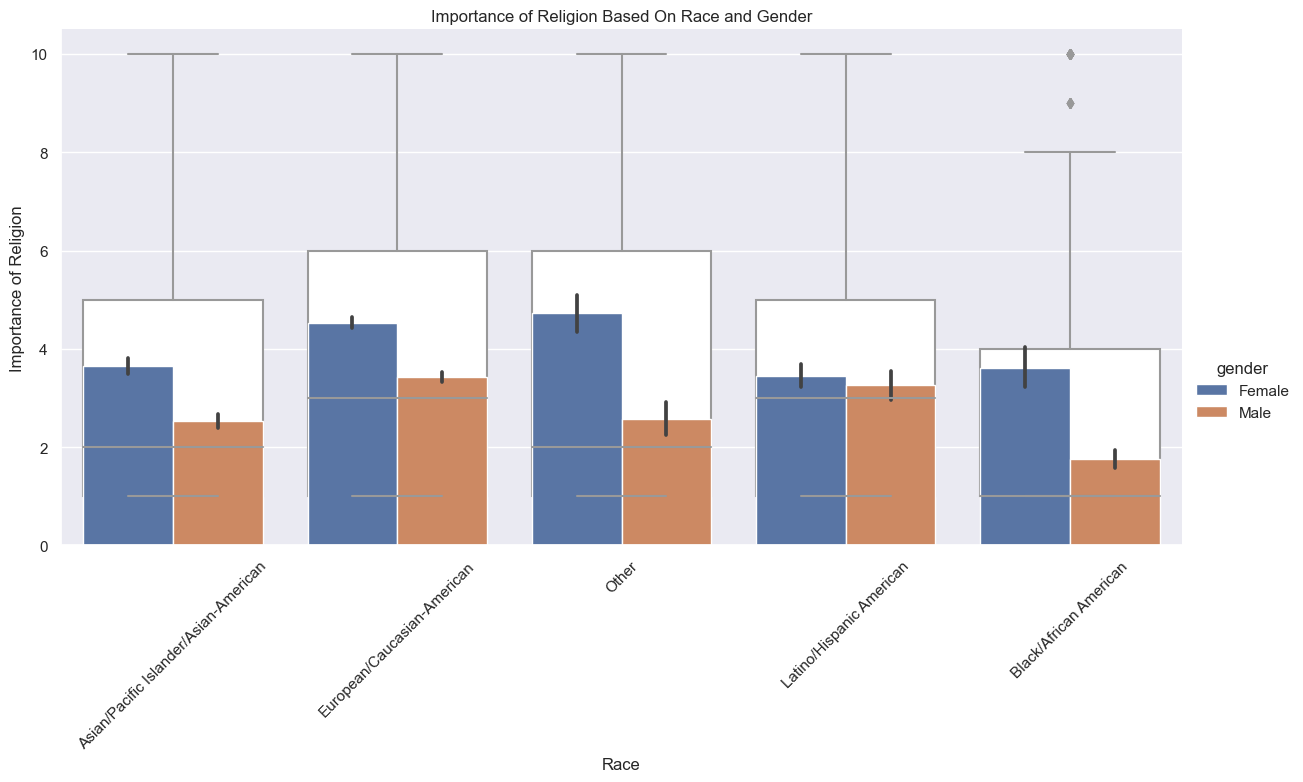

In [355]:
plt.figure(figsize=(20,6))

# Create a bar plot with mean values
g = sns.catplot(x="race_explanation", y="imprelig", hue="gender", kind="bar", data=race_rel, height=6, aspect=2)

# Create a box plot with outliers
sns.boxplot(x="race_explanation", y="imprelig", data=race_rel, dodge=False, color="white", showfliers=True, ax=g.ax)

g.set_xticklabels(rotation=45)
plt.xlabel('Race')
plt.ylabel('Importance of Religion')
plt.title('Importance of Religion Based On Race and Gender')
plt.show()


1. Religion is more important to Female

In [356]:
edu_car['field'] = edu_car['field_cd'].map({1:'Law',2:'Math',3:'Social Science, Psychologist',4: 'Medical Science, Pharmaceuticals, and Bio Tech',
5:'Engineering',6:'English/Creative Writing/ Journalism',7:'History/Religion/Philosophy',8:'Business/Econ/Finance',9:'Education, Academia', 
10:'Biological Sciences/Chemistry/Physics',11:'Social Work',12:'Undergrad/undecided',13:'Political Science/International Affairs',
14:'Film',15:'Fine Arts/Arts Administration',16:'Languages',17:'Architecture',18:'Other'})

In [357]:
edu_car_match = edu_car.groupby('field').agg({'match':['count','sum']})
edu_car_match.columns = ['total_date','positive_match']
edu_car_match = edu_car_match.reset_index()
edu_car_match['%'] = round((edu_car_match['positive_match'] / edu_car_match['total_date']) * 100,2)
edu_car_match.sort_values(by='total_date', ascending=False)

field  total_date  \
2                            Business/Econ/Finance        1925   
1            Biological Sciences/Chemistry/Physics         993   
4                                      Engineering         864   
14         Political Science/International Affairs         709   
15                    Social Science, Psychologist         696   
10                                             Law         665   
3                              Education, Academia         626   
16                                     Social Work         468   
5             English/Creative Writing/ Journalism         325   
8                      History/Religion/Philosophy         241   
11                                            Math         207   
7                    Fine Arts/Arts Administration         187   
12  Medical Science, Pharmaceuticals, and Bio Tech         143   
13                                           Other         134   
6                                             Film         126   
9                                        Languages          40   
17                             Undergrad/undecided          19   
0                                     Architecture          10   

    positive_match      %  
2              338  17.56  
1              161  16.21  
4              117  13.54  
14             119  16.78  
15             128  18.39  
10             136  20.45  
3               95  15.18  
16              50  10.68  
5               48  14.77  
8               40  16.60  
11              21  10.14  
7               22  11.76  
12              46  32.17  
13              22  16.42  
6               23  18.25  
9               12  30.00  
17               1   5.26  
0                1  10.00

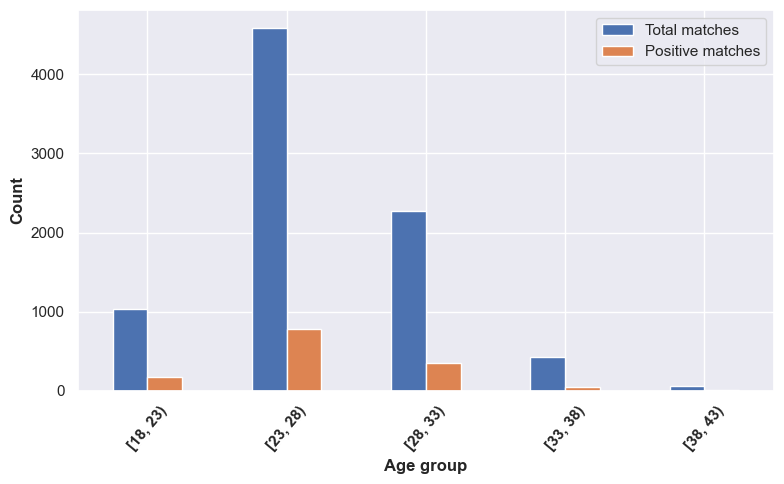

In [358]:
age_df = final_data.groupby('age').agg({'match': ['count', 'sum']})
age_df.columns = ['total_match','positive_match']
age_df = age_df.reset_index()
age_df['age_group'] = pd.cut(age_df['age'], bins=np.arange(18, 44, 5), right=False)

age_group_df = age_df.groupby('age_group').sum()

fig, ax = plt.subplots()
age_group_df.plot.bar(y=['total_match', 'positive_match'], rot=50, ax=ax)
ax.set_xlabel('Age group',fontweight='bold')
ax.set_ylabel('Count',fontweight='bold')
ax.legend(['Total matches', 'Positive matches'])
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
sns.set(font_scale=1)

# Adjust layout
fig.set_size_inches(8, 5)
plt.tight_layout()
plt.show();

In [359]:
age_group_df['%'] = (age_group_df['positive_match'] / age_group_df['total_match']) * 100
age_group_df

age  total_match  positive_match          %
age_group                                               
[18, 23)   166.6         1034             179  17.311412
[23, 28)   510.4         4583             787  17.172158
[28, 33)   325.2         2275             352  15.472527
[33, 38)   175.0          423              54  12.765957
[38, 43)   119.0           57               8  14.035088

In [360]:
final_data['age_diff'] = round(abs(final_data['age'] - final_data['age_o']),0)
age_diff_df = final_data.groupby('age_diff').agg({'match': ['count', 'sum']})
age_diff_df.columns = ['total_match','positive_match']
age_diff_df = age_diff_df.reset_index()
age_diff_df['age_differences'] = pd.cut(age_diff_df['age_diff'], bins=np.arange(0, 32, 5), right=False)

age_diff_df = age_diff_df.groupby('age_differences').agg({'total_match':'sum','positive_match':'sum'})
age_diff_df = age_diff_df.reset_index()
age_diff_df['%'] = round((age_diff_df['positive_match'] / age_diff_df['total_match']) * 100,2)

age_diff_df

age_differences  total_match  positive_match      %
0          [0, 5)         5755            1035  17.98
1         [5, 10)         2259             309  13.68
2        [10, 15)          300              30  10.00
3        [15, 20)           48               6  12.50
4        [20, 25)           10               0   0.00
5        [25, 30)            2               0   0.00

1. Most of the people age range from 18 to 33. For young people, the % is higher.
2. When the age differences increase, positive match % is decreasing

In [361]:
history['goal_exp'] = history['goal'].map({1:'Seemed like a fun night out',2:'To meet new people',3:'To get a date',4:'Looking for a serious relationship',
                                          5:'To say I did it',6:'Other'})
history['date_exp'] = history['date'].map({1:'Several times a week',2:'Twice a week',3:'Once a week',4:'Twice a month',5:'Once a month',6:'Several times a year',7:'Almost never'})
history['go_out_exp'] = history['go_out'].map({1:'Several times a week',2:'Twice a week',3:'Once a week',4:'Twice a month',5:'Once a month',6:'Several times a year',7:'Almost never'})


goal_df = history.groupby('goal_exp').agg({'match': ['count', 'sum']})
goal_df.columns = ['total_date','positive_match']
goal_df = goal_df.reset_index()
goal_df['%'] = round((goal_df['positive_match'] / goal_df['total_date'] * 100),2)

date_exp = history.groupby('date_exp').agg({'match': ['count', 'sum']})
date_exp.columns = ['total_date','positive_match']
date_exp = date_exp.reset_index()
date_exp['%'] = round((date_exp['positive_match'] / date_exp['total_date'] * 100),2)

go_out_exp = history.groupby('go_out_exp').agg({'match': ['count', 'sum']})
go_out_exp.columns = ['total_date','positive_match']
go_out_exp = go_out_exp.reset_index()
go_out_exp['%'] = round((go_out_exp['positive_match'] / go_out_exp['total_date'] * 100),2)

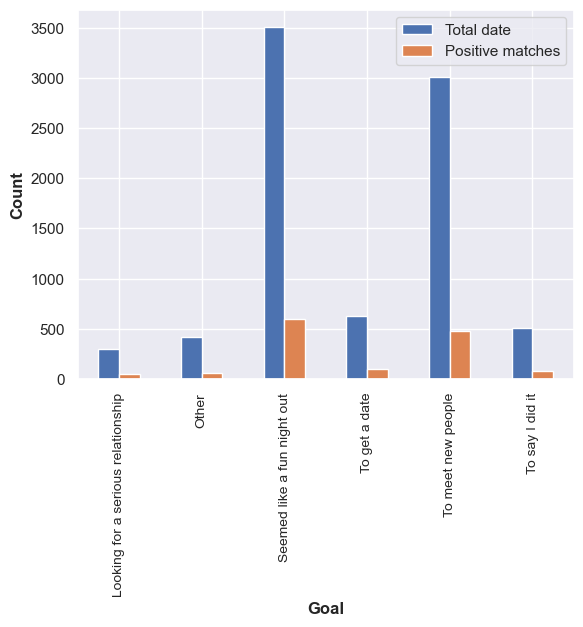

In [362]:
figsize=(10,8)
fig, ax = plt.subplots()
goal_df.plot.bar(x='goal_exp', y=['total_date', 'positive_match'], rot=90, ax=ax)
ax.set_xlabel('Goal',fontweight='bold')
ax.set_ylabel('Count',fontweight='bold')
ax.legend(['Total date', 'Positive matches'])
ax.set_xticklabels(goal_df['goal_exp'], fontsize=10)
plt.show();

In [363]:
goal_df.sort_values(by='total_date',ascending=False)

goal_exp  total_date  positive_match      %
2         Seemed like a fun night out        3505             598  17.06
4                  To meet new people        3012             484  16.07
3                       To get a date         631             100  15.85
5                     To say I did it         510              85  16.67
1                               Other         419              62  14.80
0  Looking for a serious relationship         301              51  16.94

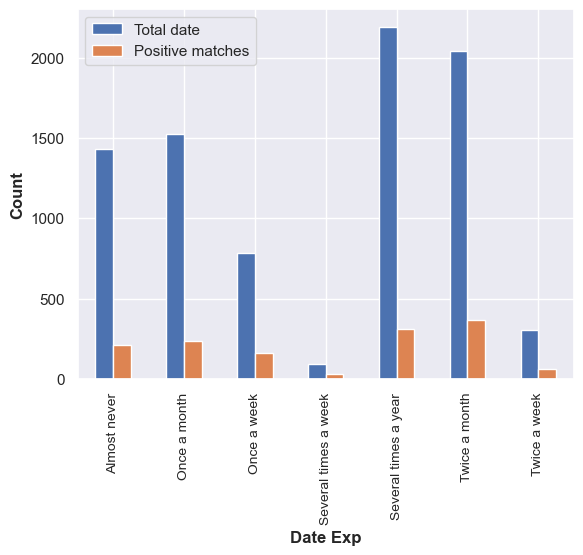

In [364]:
figsize=(10,6)
fig, ax = plt.subplots()
date_exp.plot.bar(x='date_exp', y=['total_date', 'positive_match'], rot=90, ax=ax)
ax.set_xlabel('Date Exp',fontweight='bold')
ax.set_ylabel('Count',fontweight='bold')
ax.legend(['Total date', 'Positive matches'])
ax.set_xticklabels(date_exp['date_exp'], fontsize=10)
plt.show();

In [365]:
date_exp.sort_values(by='total_date',ascending=False)

date_exp  total_date  positive_match      %
4  Several times a year        2191             313  14.29
5         Twice a month        2040             365  17.89
1          Once a month        1528             237  15.51
0          Almost never        1434             212  14.78
2           Once a week         783             159  20.31
6          Twice a week         308              65  21.10
3  Several times a week          94              29  30.85

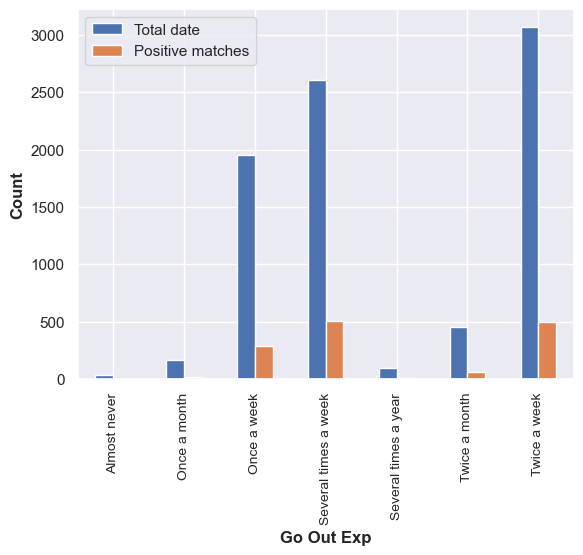

In [366]:
figsize=(10,6)
fig, ax = plt.subplots()
go_out_exp.plot.bar(x='go_out_exp', y=['total_date', 'positive_match'], rot=90, ax=ax)
ax.set_xlabel('Go Out Exp',fontweight='bold')
ax.set_ylabel('Count',fontweight='bold')
ax.legend(['Total date', 'Positive matches'])
ax.set_xticklabels(go_out_exp['go_out_exp'], fontsize=10)
plt.show();

In [367]:
go_out_exp.sort_values(by='total_date',ascending=False)

go_out_exp  total_date  positive_match      %
6          Twice a week        3069             494  16.10
3  Several times a week        2610             507  19.43
2           Once a week        1949             289  14.83
5         Twice a month         450              57  12.67
1          Once a month         164              19  11.59
4  Several times a year          99              13  13.13
0          Almost never          37               1   2.70

People who go out or date several times a week, twice a week have higher positive match %.

### Hobbies

Before starting the activities, the participants were asked if they had any hobbies. They were given 18 options to answer.

In [368]:
hobies.corr()

# There will be heatmap

go_out    sports  tvsports  exercise    dining   museums  \
go_out    1.000000 -0.127555 -0.010071 -0.084177 -0.124684  0.051132   
sports   -0.127555  1.000000  0.468342  0.398777 -0.063250 -0.125750   
tvsports -0.010071  0.468342  1.000000  0.216923 -0.055333 -0.079578   
exercise -0.084177  0.398777  0.216923  1.000000  0.085766 -0.007145   
dining   -0.124684 -0.063250 -0.055333  0.085766  1.000000  0.386654   
museums   0.051132 -0.125750 -0.079578 -0.007145  0.386654  1.000000   
art       0.041584 -0.123007 -0.104606 -0.010747  0.341653  0.857282   
hiking    0.037994  0.181131 -0.022710  0.074579  0.077878  0.179415   
gaming    0.038909  0.121509  0.264029 -0.000323  0.059983 -0.077724   
clubbing -0.040264  0.054666  0.072996  0.021302  0.231184  0.114054   
reading   0.063357 -0.137021 -0.163428  0.011574  0.105242  0.327026   
tv        0.053881 -0.095420  0.250075  0.027974  0.112238  0.026405   
theater   0.044335 -0.251934 -0.089223 -0.013197  0.305762  0.549553   
movies    0.074958 -0.153649 -0.021095 -0.054171  0.231772  0.318911   
concerts  0.007125 -0.015068  0.050081 -0.051323  0.218762  0.379141   
music    -0.021104  0.009814  0.043917  0.011841  0.197527  0.270241   
shopping -0.031726 -0.100760  0.033366  0.088181  0.406955  0.228635   
yoga     -0.023014 -0.037454 -0.049840  0.102409  0.172141  0.259900   
gender    0.017408  0.227966  0.150702 -0.087081 -0.205417 -0.213418   
match    -0.060291  0.021900 -0.005228  0.009861  0.033808  0.014879   

               art    hiking    gaming  clubbing   reading        tv  \
go_out    0.041584  0.037994  0.038909 -0.040264  0.063357  0.053881   
sports   -0.123007  0.181131  0.121509  0.054666 -0.137021 -0.095420   
tvsports -0.104606 -0.022710  0.264029  0.072996 -0.163428  0.250075   
exercise -0.010747  0.074579 -0.000323  0.021302  0.011574  0.027974   
dining    0.341653  0.077878  0.059983  0.231184  0.105242  0.112238   
museums   0.857282  0.179415 -0.077724  0.114054  0.327026  0.026405   
art       1.000000  0.196068 -0.070327  0.138738  0.241091  0.019594   
hiking    0.196068  1.000000  0.146841  0.021053  0.047574 -0.145101   
gaming   -0.070327  0.146841  1.000000  0.179802 -0.069000  0.195072   
clubbing  0.138738  0.021053  0.179802  1.000000 -0.079928  0.019150   
reading   0.241091  0.047574 -0.069000 -0.079928  1.000000 -0.001388   
tv        0.019594 -0.145101  0.195072  0.019150 -0.001388  1.000000   
theater   0.526904  0.074554 -0.040899  0.122359  0.210994  0.224458   
movies    0.315224  0.016064  0.015206  0.116911  0.108807  0.341171   
concerts  0.404519  0.182721  0.097410  0.125639  0.092064  0.074246   
music     0.297335  0.057844  0.030485  0.132533  0.083690  0.084809   
shopping  0.220261 -0.110184  0.087416  0.200013 -0.020218  0.453058   
yoga      0.295652  0.225211  0.000991  0.062251  0.060522  0.023374   
gender   -0.223127 -0.082739  0.222469 -0.064827 -0.115595 -0.171513   
match     0.031694  0.024491  0.012692  0.055508  0.020496 -0.014283   

           theater    movies  concerts     music  shopping      yoga  \
go_out    0.044335  0.074958  0.007125 -0.021104 -0.031726 -0.023014   
sports   -0.251934 -0.153649 -0.015068  0.009814 -0.100760 -0.037454   
tvsports -0.089223 -0.021095  0.050081  0.043917  0.033366 -0.049840   
exercise -0.013197 -0.054171 -0.051323  0.011841  0.088181  0.102409   
dining    0.305762  0.231772  0.218762  0.197527  0.406955  0.172141   
museums   0.549553  0.318911  0.379141  0.270241  0.228635  0.259900   
art       0.526904  0.315224  0.404519  0.297335  0.220261  0.295652   
hiking    0.074554  0.016064  0.182721  0.057844 -0.110184  0.225211   
gaming   -0.040899  0.015206  0.097410  0.030485  0.087416  0.000991   
clubbing  0.122359  0.116911  0.125639  0.132533  0.200013  0.062251   
reading   0.210994  0.108807  0.092064  0.083690 -0.020218  0.060522   
tv        0.224458  0.341171  0.074246  0.084809  0.453058  0.023374   
theater   1.000000  0.517888  0.412829  0.255080  

In [369]:
hobies_by_gender = hobies.groupby('gender')[hobies.columns[:-2]].mean().T
hobies_by_gender.rename(columns={1:'Male', 0:'Female'}, inplace=True)
hobies_by_gender = hobies_by_gender.reset_index()
hobies_by_gender = hobies_by_gender.rename_axis('index', axis='columns')
hobies_by_gender = hobies_by_gender.rename(columns={'index': 'hobbie'})

In [370]:
import plotly.graph_objects as go

fig = go.Figure()

categories = hobies_by_gender['hobbie']
values_male = hobies_by_gender['Male']
values_female = hobies_by_gender['Female']

fig.add_trace(go.Scatterpolar(
      r=values_male,
      theta=categories,
      fill='toself',
      name='Male Participants',
      line_color='cyan'
))

fig.add_trace(go.Scatterpolar(
      r=values_female,
      theta=categories,
      fill='toself',
      name='Female Participants',
      line_color='pink'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 10]
    )),
  showlegend=True
)

fig.update_layout(
    title={
        'text': "Men and Women interest per activity (1-10)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

fig.show()

As we can see there are differences in hobbies by gender:

- Women prefer dining, museums, art, tv, theater, shopping and yoga.
- While men prefer sports, tv sports and gaming.
- Both genres have similar tastes in hiking, exercise, reading, clubbing, movies, music and going out.

In [371]:
#Attributes & Preferences

In [372]:
df_gender_m = preferences.loc[preferences['gender'] == 1].groupby('match').mean()
df_gender_m = df_gender_m.rename(columns={'attr1_1': 'Attraction','sinc1_1': 'Sincerity',
'intel1_1': 'Intelligence', 'fun1_1': 'Fun', 'amb1_1': 'Ambition','shar1_1': 'Shared interests'
})
df_gender_m.drop(['gender'],axis=1, inplace=True)
df_gender_m = df_gender_m.rename(index={0: 'No match',1: 'Match'})
print("Preferences by men.")
df_gender_m

Preferences by men.


Attraction  Sincerity  Intelligence       Fun  Ambition  \
match                                                               
No match    0.266668   0.278592      0.390269  0.353985  0.162215   
Match       0.280155   0.258291      0.393446  0.363789  0.158685   

          Shared interests  
match                       
No match          0.370462  
Match             0.344772

In [373]:
df_gender_f = preferences.loc[preferences['gender'] == 0].groupby('match').mean()
df_gender_f = df_gender_f.rename(columns={'attr1_1': 'Attraction','sinc1_1': 'Sincerity',
'intel1_1': 'Intelligence', 'fun1_1': 'Fun', 'amb1_1': 'Ambition','shar1_1': 'Shared interests'
})
df_gender_f.drop(['gender'],axis=1, inplace=True)
df_gender_f = df_gender_f.rename(index={0: 'No match',1: 'Match'})
print("Preferences by Woman.")
df_gender_f

Preferences by Woman.


Attraction  Sincerity  Intelligence       Fun  Ambition  \
match                                                               
No match    0.181388   0.305457      0.418619  0.340874  0.241171   
Match       0.177981   0.305606      0.425584  0.358318  0.241774   

          Shared interests  
match                       
No match          0.426485  
Match             0.397640

                    female      male
match                Match     Match
Attraction        0.177981  0.280155
Sincerity         0.305606  0.258291
Intelligence      0.425584  0.393446
Fun               0.358318  0.363789
Ambition          0.241774  0.158685
Shared interests  0.397640  0.344772


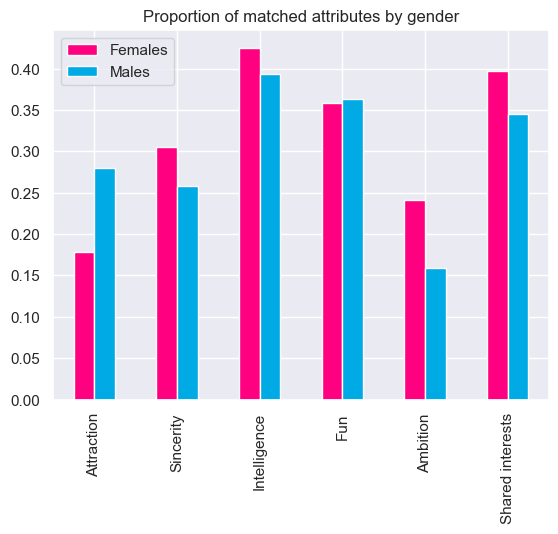

In [374]:
df_concat = pd.concat([df_gender_f, df_gender_m], keys=['female', 'male'])
df_plot = df_concat.loc[(['female', 'male'], 'Match'), :]
df_plot=df_plot.T
print(df_plot)
df_plot.plot(kind='bar', color=['#ff0080','#00aae4'])
ax.set_xlabel('Attributes')
ax.set_ylabel('Proportion (%)')
plt.title('Proportion of matched attributes by gender')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.5), borderaxespad=2)
plt.legend(labels=['Females', 'Males'])
plt.show()

In [375]:
# Will have another table for the whole data

In [376]:
att_g = opposite_preferences.loc[opposite_preferences['gender'] == 1].groupby('match').mean()
att_g = att_g.rename(columns={'attr2_1': 'Attraction','sinc2_1': 'Sincerity',
'intel2_1': 'Intelligence', 'fun2_1': 'Fun', 'amb2_1': 'Ambition','shar2_1': 'Shared interests'
})
att_g.drop(['gender'],axis=1, inplace=True)
att_g= att_g.rename(index={0: 'No_match',1: 'Match'})
print("Preferences that men think that woman have")
att_g

Preferences that men think that woman have


Attraction  Sincerity  Intelligence       Fun  Ambition  \
match                                                               
No_match    0.248789   0.303862      0.404922  0.365169  0.283456   
Match       0.260306   0.299399      0.412948  0.348870  0.287314   

          Shared interests  
match                       
No_match          0.371630  
Match             0.354479

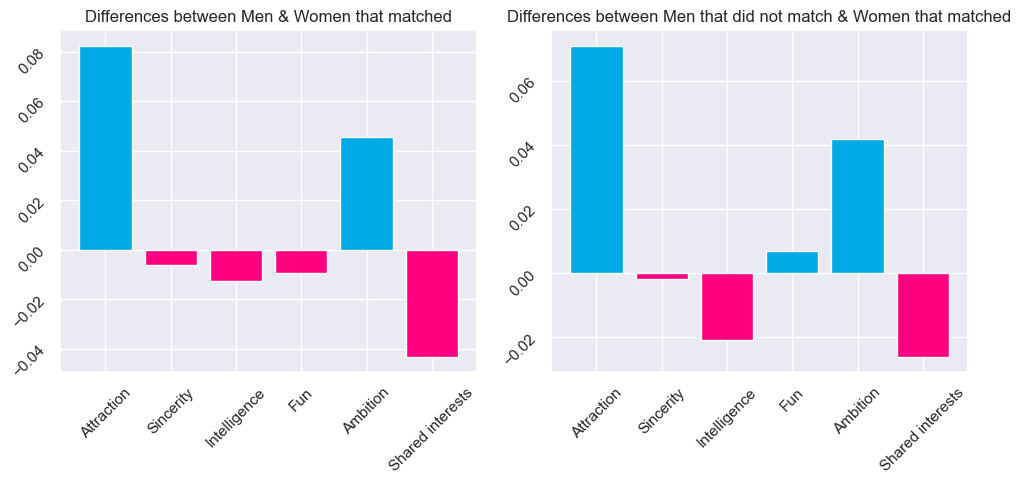

In [377]:
# Differences
diff_1 = att_g.loc['Match'] - df_gender_f.loc['Match']
diff_2 = att_g.loc['No_match'] - df_gender_f.loc['Match']

# Figure and subplots

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
axs[0].bar(diff_1.index, diff_1, color=['#ff0080' if x < 0 else '#00aae4' for x in diff_1])
axs[0].set_title('Differences between Men & Women that matched')
axs[0].tick_params( labelrotation=45)

# Subplot 2
axs[1].bar(diff_2.index, diff_2, color=['#ff0080' if x < 0 else '#00aae4' for x in diff_2])
axs[1].set_title('Differences between Men that did not match & Women that matched')
axs[1].tick_params( labelrotation=45)
# # Bar plot 1
# ax1.bar(diff1.index, diff1.values)
# ax1.set(title='Differences in attribute means (Matched)', ylabel='Difference')
# ax1.tick_params(axis='x', labelrotation=45)

# # Bar plot 2
# ax2.bar(diff2.index, diff2.values)
# ax2.set(title='Differences in attribute means (Not matched)', ylabel='Difference')
# ax2.tick_params(axis='x', labelrotation=45)

# Adjust layout
fig.tight_layout()
plt.show()




# Keep it in the notebook but not in the presentation

In [378]:
att_f = opposite_preferences.loc[opposite_preferences['gender'] == 0].groupby('match').mean()
att_f = att_f.rename(columns={'attr2_1': 'Attraction','sinc2_1': 'Sincerity',
'intel2_1': 'Intelligence', 'fun2_1': 'Fun', 'amb2_1': 'Ambition','shar2_1': 'Shared interests'
})
att_f.drop(['gender'],axis=1, inplace=True)
att_f= att_f.rename(index={0: 'No_match',1: 'Match'})
print("Preferences that womem think that men have")
att_f

Preferences that womem think that men have


Attraction  Sincerity  Intelligence       Fun  Ambition  \
match                                                               
No_match    0.354360   0.227533      0.310147  0.373480  0.185470   
Match       0.356606   0.221232      0.323859  0.382864  0.181589   

          Shared interests  
match                       
No_match          0.424301  
Match             0.399802

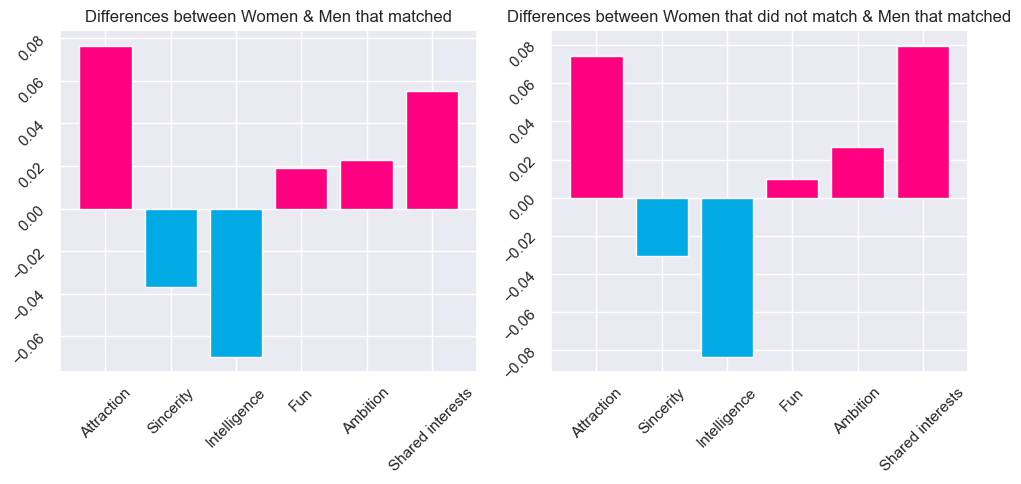

In [379]:
# Differences
diff_1 = att_f.loc['Match'] - df_gender_m.loc['Match']
diff_2 = att_f.loc['No_match'] - df_gender_m.loc['Match']

# Figure and subplots

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
axs[0].bar(diff_1.index, diff_1, color=['#ff0080' if x > 0 else '#00aae4' for x in diff_1])
axs[0].set_title('Differences between Women & Men that matched')
axs[0].tick_params( labelrotation=45)

# Subplot 2
axs[1].bar(diff_2.index, diff_2, color=['#ff0080' if x > 0 else '#00aae4' for x in diff_2])
axs[1].set_title('Differences between Women that did not match & Men that matched')
axs[1].tick_params( labelrotation=45)


# Adjust layout
fig.tight_layout()
plt.show()

In [380]:
patt_m = your_rate_general.loc[your_rate_general['gender'] == 1].groupby('match').mean()
patt_m = patt_m.rename(columns={'attr3_1': 'Attraction','sinc3_1': 'Sincerity',
'intel3_1': 'Intelligence', 'fun3_1': 'Fun', 'amb3_1': 'Ambition','shar3_1': 'Shared interests'
})
patt_m.drop(['gender'],axis=1, inplace=True)
patt_m= patt_m.rename(index={0: 'No_match',1: 'Match'})
print("How men see their own attributes")
patt_m

How men see their own attributes


Attraction  Sincerity       Fun  Intelligence  Ambition
match                                                            
No_match    0.615154   0.766624  0.682078      0.781719  0.685681
Match       0.638587   0.772645  0.731341      0.790476  0.718841

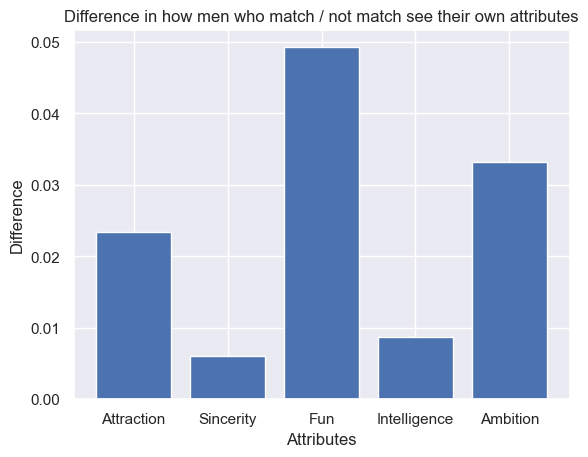

In [381]:
diff = patt_m.diff().iloc[1]

# Create bar plot
plt.bar(diff.index, diff, color=['r' if x < 0 else 'b' for x in diff])

# Add labels and title
plt.xlabel('Attributes')
plt.ylabel('Difference')
plt.title('Difference in how men who match / not match see their own attributes')

# Show plot
plt.show()



# How man difference between match and no match man, stack bar plot

In general, men rate themselves higher on their attributes than that how they rate women, and men who make match rate themselves higher than those who do not.

In [382]:
patt_f = your_rate_general.loc[your_rate_general['gender'] == 0].groupby('match').mean()
patt_f = patt_f.rename(columns={'attr3_1': 'Attraction','sinc3_1': 'Sincerity',
'intel3_1': 'Intelligence', 'fun3_1': 'Fun', 'amb3_1': 'Ambition','shar3_1': 'Shared interests'
})
patt_f.drop(['gender'],axis=1, inplace=True)
patt_f= patt_f.rename(index={0: 'No_match',1: 'Match'})
print("How women see their own attributes")
patt_f

How women see their own attributes


Attraction  Sincerity       Fun  Intelligence  Ambition
match                                                            
No_match    0.650293   0.809388  0.736191      0.760406  0.708035
Match       0.660326   0.803261  0.740580      0.754037  0.688406

The same happens with women, they tend to evaluate themselves better than men, and those who find a partner evaluate themselves better than those who don't.

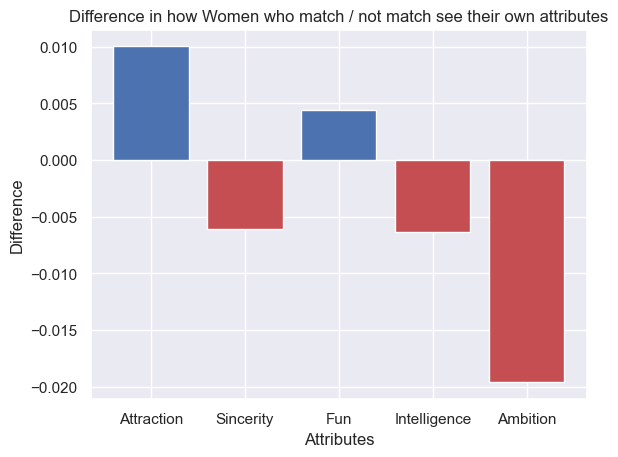

In [383]:
diff = patt_f.diff().iloc[1]

# Create bar plot
plt.bar(diff.index, diff, color=['r' if x < 0 else 'b' for x in diff])

# Add labels and title
plt.xlabel('Attributes')
plt.ylabel('Difference')
plt.title('Difference in how Women who match / not match see their own attributes')

# Show plot
plt.show()

In the case of women. they tend to rate themselves higher than they rate their potential mates, but women that match tend to rate themselves as less sincere, intelligent, and ambitious than those who don't.

In [384]:
esti_m = other_rate_your_idea.loc[other_rate_your_idea['gender'] == 1].groupby('match').mean()
esti_m = esti_m.rename(columns={'attr5_1': 'Attraction','sinc5_1': 'Sincerity',
'intel5_1': 'Intelligence', 'fun5_1': 'Fun', 'amb5_1': 'Ambition'
})
esti_m.drop(['gender'],axis=1, inplace=True)
esti_m= esti_m.rename(index={0: 'No_match',1: 'Match'})
print("How men think women are seeing them")
esti_m

How men think women are seeing them


Attraction  Sincerity  Intelligence       Fun  Ambition
match                                                            
No_match    0.614155   0.760908      0.741398  0.698202  0.787132
Match       0.620471   0.759903      0.750311  0.725181  0.810306

In [385]:
dfTWM = esti_m.sub(patt_m)
dfTWM

Ambition  Attraction       Fun  Intelligence  Sincerity
match                                                            
No_match  0.101452   -0.000999  0.016124     -0.040321  -0.005716
Match     0.091465   -0.018116 -0.006159     -0.040166  -0.012742

We can see that they feel more ambicious than how they think that women see them, on the other attributes they tend think that other evaluated with a lower punctuation than how the see themselves.

In [386]:
wsee=df_gender_f.drop(['Shared interests'],axis=1)
wsee.rename(index={'No match':'No_match'}, inplace=True)

In [387]:
dfWM = esti_m.sub(wsee)
print('Difference between how they see themselves and how women see them')
dfWM

Difference between how they see themselves and how women see them


Attraction  Sincerity  Intelligence       Fun  Ambition
match                                                            
No_match    0.432767   0.455451      0.322779  0.357328  0.545961
Match       0.442490   0.454297      0.324727  0.366863  0.568532

There is a big difference between how they see themselves and how women see them in both groups.

In [388]:
# Conculouisn

# 3. Machine Learning

## 3.1 Logistic Regression

In [45]:
X = final_data.drop(['match','dec_o','dec'], axis=1)
y = final_data['match']

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.33, random_state=42,stratify=y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=final_data.match)

In [48]:
log_reg_default = LogisticRegression(random_state=42)

log_reg_default.fit(X_train,y_train)

y_default_prediction = log_reg_default.predict(X_val)

print(confusion_matrix(y_val,y_default_prediction))
print(classification_report(y_val,y_default_prediction))

[[1365   42]
 [ 201   76]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1407
           1       0.64      0.27      0.38       277

    accuracy                           0.86      1684
   macro avg       0.76      0.62      0.65      1684
weighted avg       0.83      0.86      0.83      1684



In [49]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

log_reg_smote = LogisticRegression(random_state = 42)

log_reg_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

<AxesSubplot:title={'center':'Class distribution after appying SMOTE'}, xlabel='match'>

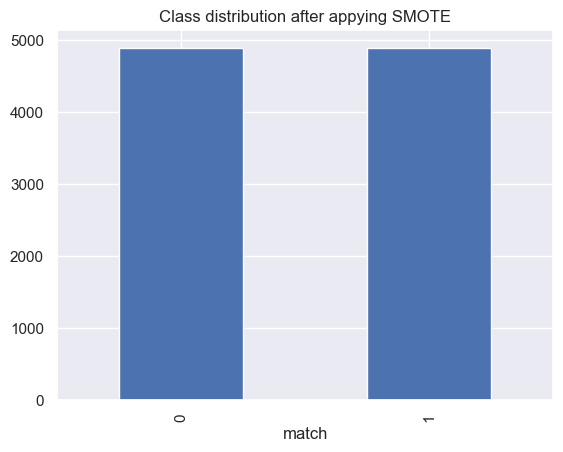

In [412]:
pd.Series(y_train_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='match')

In [57]:
y_pred_smote = log_reg_smote.predict(X_val)

print(classification_report(y_val, y_pred_smote))

print(confusion_matrix(y_val,y_pred_smote))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1407
           1       0.37      0.75      0.50       277

    accuracy                           0.75      1684
   macro avg       0.65      0.75      0.66      1684
weighted avg       0.84      0.75      0.78      1684

[[1055  352]
 [  70  207]]


In [54]:
log_reg_grid = LogisticRegression(random_state = 42)
grid_param = {'penalty':['l1', 'l2','None'],
              'max_iter': [1000,2500,5000],
              'solver': ['newton-cg','lbfgs','saga'],
              'C': np.logspace(-4, 4, 10)
             }

In [430]:
from sklearn.model_selection import GridSearchCV


clf = GridSearchCV(log_reg_grid, param_grid = grid_param, cv=3, verbose=True, n_jobs=-1)

In [431]:
best_clf = clf.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


In [432]:
best_clf.best_estimator_

LogisticRegression(C=0.3593813663804626, max_iter=1000, random_state=42,
                   solver='newton-cg')

In [433]:
y_pred = best_clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1407
           1       0.42      0.68      0.52       277

    accuracy                           0.79      1684
   macro avg       0.67      0.75      0.69      1684
weighted avg       0.84      0.79      0.81      1684



In [57]:
parameters = {'logistic_Reg__penalty':['l1', 'l2','none'],
              'logistic_Reg__max_iter': [1000, 2500, 5000],
              'logistic_Reg__solver': ['newton-cg', 'lbfgs', 'saga'],
              'logistic_Reg__C': np.logspace(-4, 4, 10)
             }

In [58]:
from sklearn.pipeline import Pipeline
std_slc = StandardScaler()
log_reg_scaled = LogisticRegression(random_state = 42)

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('logistic_Reg', log_reg_scaled)])


In [59]:
clf_GS = GridSearchCV(pipe, parameters)

In [60]:
best_clf_pipeline = clf_GS.fit(X_train_resampled, y_train_resampled)

In [61]:
best_clf_pipeline.best_estimator_

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.046415888336127774, max_iter=1000,
                                    random_state=42, solver='newton-cg'))])

In [62]:
y_pred_pl = best_clf_pipeline.predict(X_val)
print(classification_report(y_val, y_pred_pl))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1407
           1       0.41      0.68      0.51       277

    accuracy                           0.79      1684
   macro avg       0.67      0.75      0.69      1684
weighted avg       0.84      0.79      0.81      1684



## 3.2 Random Forest

## 3.2 Neurol Networks